In [ ]:
import sys
sys.path.append('core')
from PIL import Image
import argparse
import os
import time
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import datasets
from utils import flow_viz
from utils import frame_utils

from raft import RAFT
from utils.utils import InputPadder, forward_interpolate
from IPython.display import clear_output
from scipy.spatial.transform import Rotation as R
import copy
import torchvision.models as models
import torch.nn as nn
import cv2

In [2]:
class PoseTransformer2(nn.Module):
    def __init__(self, num_layers=12, embed_dim=512, num_heads=8, ff_dim=512, 
                 dropout=0.1, out_dim=512):
        super().__init__()
        
        self.pos_embedding = nn.Parameter(torch.randn(1, 361, embed_dim))  # 19x19=361 tokens
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True  # Pre-layer normalization
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Output MLP for pose regression
        self.fc1 = nn.Linear(embed_dim, out_dim)
        self.embed_dim = embed_dim

    def forward(self, x):
        B = x.shape[0]
        x = x.view(B, self.embed_dim, -1).permute(0, 2, 1)  # (B, 361, embed_dim)
        # x = x + self.pos_embedding
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        return x

In [3]:
class PoseTransformer(nn.Module):
    def __init__(self, in_dim=2, num_layers=12, embed_dim=512, num_heads=8, ff_dim=512, 
                 dropout=0.1, out_dim=512):
        super().__init__()
        
        # self.pos_embedding = nn.Parameter(torch.randn(1, 361, embed_dim))  # 19x19=361 tokens
        self.fc0 = nn.Linear(in_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True  # Pre-layer normalization
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Output MLP for pose regression
        self.fc1 = nn.Linear(embed_dim, out_dim)
        self.embed_dim = embed_dim

    def forward(self, x):
        x = self.fc0(x)
        B = x.shape[0]
        x = x.view(B, self.embed_dim, -1).permute(0, 2, 1)  # (B, 361, embed_dim)
        # x = x + self.pos_embedding
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        return x

In [4]:
class ModResNet2(nn.Module):
    def __init__(self, in_chans, out):
        super(ModResNet2, self).__init__()
        original_model = models.resnet101(pretrained=True)
        original_model.conv1 = nn.Conv2d(
                    in_channels=in_chans,  # Change from 3 to 1 to accept grayscale images
                    out_channels=original_model.conv1.out_channels,
                    kernel_size=original_model.conv1.kernel_size,
                    stride=original_model.conv1.stride,
                    padding=original_model.conv1.padding,
                    bias=original_model.conv1.bias)
        self.features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            original_model.relu,
            original_model.maxpool,
            original_model.layer1,
            original_model.layer2,
            original_model.layer3,
            original_model.layer4
        )
        self.avgpool = original_model.avgpool
        num_features = original_model.fc.in_features
        num_out_feas = out
        original_model.fc = nn.Linear(num_features, num_out_feas)
        self.fc = original_model.fc
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out_fc = self.fc(x)
        return out_fc

In [5]:
class SiamesePoseNet3b_trans2d(nn.Module):
    def __init__(self):
        super(SiamesePoseNet3b_trans2d, self).__init__()
        self.model = ModResNet2(1,512)
        self.model2a = PoseTransformer2(embed_dim=512, out_dim=2, num_layers=2)
        self.model2b = PoseTransformer2(embed_dim=512, out_dim=2, num_layers=2)
        self.model2d = PoseTransformer2(embed_dim=512, out_dim=4, num_layers=2)
    def forward(self, rgbd1):
        f1_rgb = self.model(rgbd1[:,0:1,:,:])
        f2_rgb = self.model(rgbd1[:,1:,:,:])
        pfocal = self.model2a(f1_rgb - f2_rgb)
        pcenters = self.model2b(f1_rgb - f2_rgb)
        pquat = self.model2d(f1_rgb - f2_rgb)
        return pfocal, pcenters, [], pquat

In [6]:
class homo_opt2(nn.Module):
    def __init__(self):
        super(homo_opt2, self).__init__()
        self.model = ModResNet2(1,512)
        self.model2e = PoseTransformer(in_dim=2, out_dim=512, num_layers=2) #2
        self.model2f = PoseTransformer(in_dim=512, out_dim=2, num_layers=2)#8
    def forward(self, rgbd1, uvc=None):
        f1_rgb = self.model(rgbd1[:,0:1,:,:])
        f2_rgb = self.model(rgbd1[:,1:,:,:])
        
        # fcomb = self.model(rgbd1)
        p_all_del_uv = []
        if uvc is not None:
            for ii in range(len(uvc)):
                sh = uvc[ii].shape[0]
                Nmax = 20000
                rndd = sh//Nmax
                inter_p = []
                for jj in range(rndd):
                    nnmin, nnmax = jj*Nmax, jj*Nmax + Nmax
                    f_uv = self.model2e(uvc[ii][:,0:2][nnmin:nnmax,:].cuda())
                    p_del_uv_ = self.model2f(f_uv + f1_rgb[ii,:] - f2_rgb[ii,:]) #self.model2f(f_uv + fcomb[ii,:]) #
                    inter_p.append(p_del_uv_)
                if (sh - rndd*Nmax) > 0:
                    nnmin, nnmax = rndd*Nmax, sh
                    f_uv = self.model2e(uvc[ii][:,0:2][nnmin:nnmax,:].cuda())
                    p_del_uv_ = self.model2f(f_uv + f1_rgb[ii,:] - f2_rgb[ii,:]) #self.model2f(f_uv + fcomb[ii,:]) #
                    inter_p.append(p_del_uv_)
                
                p_del_uv = torch.vstack(inter_p)  
                p_all_del_uv.append(p_del_uv)
        return p_all_del_uv

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [8]:
## RAFT
sys.path.append('core')
parser = argparse.ArgumentParser()
parser.add_argument('--model', help="restore checkpoint")
parser.add_argument('--dataset', help="dataset for evaluation")
parser.add_argument('--small', action='store_true', help='use small model')
parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation')
# args = parser.parse_args()

args, unknown = parser.parse_known_args()
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load('./models/raft-things.pth')) #model.load_state_dict(torch.load(args.model))

# model.cuda()
model = model.eval().to(device)
mod0 = copy.deepcopy(model).eval()
modref = copy.deepcopy(model).eval()

modh = SiamesePoseNet3b_trans2d().to(device)
modh = modh.eval()
# modref = homo_opt2().cuda()

/home/thomas/anaconda3/envs/yolov8/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/thomas/anaconda3/envs/yolov8/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/thomas/anaconda3/envs/yolov8/lib/python3.9/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [9]:
## Flow_former
import sys
sys.path.append('/home/thomas/FlowFormer-Official')
sys.path.append('/home/thomas/FlowFormer-Official/core_f')
from configs.default import get_cfg
from configs.things_eval import get_cfg as get_things_cfg
from configs.small_things_eval import get_cfg as get_small_things_cfg
from core_f.utils.misc import process_cfg
import datasets
from core_f.utils import flow_viz
from core_f.utils import frame_utils
# from FlowFormer import FlowFormer
from core_f.FlowFormer import build_flowformer
import argparse
import torch


parser = argparse.ArgumentParser()
parser.add_argument('--model', help="restore checkpoint")
parser.add_argument('--dataset', help="dataset for evaluation")
parser.add_argument('--small', action='store_true', help='use small model')
parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation')
args, unknown = parser.parse_known_args()
# cfg = get_cfg()
# if args.small:
#     cfg = get_small_things_cfg()
# else:
cfg = get_things_cfg()
cfg.update(vars(args))
cfg.model = "/home/thomas/FlowFormer-Official/things.pth"
model_ff = torch.nn.DataParallel(build_flowformer(cfg))
model_ff.load_state_dict(torch.load(cfg.model))
# model.cuda()
model_ff = model_ff.eval().to(device)



In [10]:
from core_f.utils.utils import InputPadder, forward_interpolate

In [60]:
# ### Roller

# K_mm = np.array([[508.3997, 0, 316.0652],[0,677.8663,254.0068],[0, 0, 1]])
# nimg_0 = [10,36,4,49,7]#,5] 
# mah_dir = '/home/thomas/ScoreFunc/roller/'
# def calc_ffbx(K_mm, Rts, xyz_0, trs, th=50):
#     zuv0 = K_mm@Rts@(xyz_0.T - trs.reshape(-1,1))
#     uv_0 = (zuv0[0:2,:]/zuv0[2:,:]).astype(np.int16)
#     uv_0_ = np.array(uv_0)
#     uv_0_[:,uv_0[0,:]<0.0] = 0.0
#     uv_0_[:,uv_0[0,:]>=640] = 639
#     uv_0_[:,uv_0[1,:]<0.0] = 0.0
#     uv_0_[:,uv_0[1,:]>=480] = 479
#     # flg = (uv_0[0,:]>=0) * (uv_0[0,:]<640) * (uv_0[1,:]>=0) * (uv_0[1,:]<480)
#     umin, umax = np.min(uv_0_[0,:]), np.max(uv_0_[0,:])
#     vmin, vmax = np.min(uv_0_[1,:]), np.max(uv_0_[1,:])
#     ff0 = True#((umax-umin)>=th) * ((vmax-vmin)>=th) #True#np.sum(flg)>=2#
#     return ff0, uv_0
# BXMs = []
# for idx in nimg_0:
#     trs = np.load(mah_dir+'CameraCenter_img'+str(idx)+'.npy').flatten()
#     Rts = np.load(mah_dir+'Rotation_img'+str(idx)+'.npy')
#     # xyz_0 = np.array([[0.0,-0.2,-0.2],[0.0,-0.2,0.36],[0.0,1.3,0.36],[0.0,1.3,-0.2]])
#     # xyz_1 = np.array([[0.0,-0.2,0.28],[0.0,-0.2,0.9],[0.0,1.3,0.9],[0.0,1.3,0.28]])

#     xyz_0 = np.array([[0.0,-0.2,-0.4],[0.0,-0.2,0.36],[0.0,1.5,0.36],[0.0,1.5,-0.4]]) #-0.2, 1.3
#     xyz_1 = np.array([[0.0,-0.2,0.28],[0.0,-0.2,0.9],[0.0,1.5,0.9],[0.0,1.5,0.28]])
#     xyz_2 = np.array([[0.0,-0.2,-0.2],[0.0,-0.2,0.9],[0.65,-0.2,0.9],[0.65,-0.2,-0.2]])

#     bxm = []
#     ff0, uv_0 = calc_ffbx(K_mm, Rts, xyz_0, trs)
#     ff1, uv_1 = calc_ffbx(K_mm, Rts, xyz_1, trs)
#     # ff2, uv_2 = calc_ffbx(K_mm, Rts, xyz_2, trs)
#     if ff0:
#         bxm.append(uv_0.T)
#     else:
#         bxm.append(None)
#     if ff1:
#         bxm.append(uv_1.T)
#     else:
#         bxm.append(None)
#     # if ff2:
#     #     bxm.append(uv_2.T)
#     # else:
#     #     bxm.append(None)
#     BXMs.append(bxm)

# IMGS, TRNS, QUTS = [], [], []
# for idx in nimg_0:
#     img_idx = cv2.imread(mah_dir+'img'+str(idx)+'.png')
#     IMGS.append(cv2.cvtColor(img_idx,cv2.COLOR_BGR2RGB)) 
#     try:
#         trs = np.load(mah_dir+'CameraCenter_img'+str(idx)+'.npy').flatten()
#         Rtrs = np.load(mah_dir+'Rotation_img'+str(idx)+'.npy')
#         # qtt = np.array(R.from_matrix(Rtrs).as_quat()).tolist()
#         # qts = np.array([qtt[-1],qtt[0],qtt[1],qtt[2]])
#         TRNS.append(trs) 
#         QUTS.append(Rtrs)
#     except:
#         TRNS.append(None) 
#         QUTS.append(None)  

In [13]:
# ## Locker
# K_mm = np.array([[508.3997, 0, 316.0652],[0,677.8663,254.0068],[0, 0, 1]])
# nimg_0 = [1,3,4,12,27,32,40,38,26,31,39]
# mah_dir = '/home/thomas/ScoreFunc/locker/'
# IMGS, TRNS, QUTS = [], [], []
# for idx in nimg_0:
#     img_idx = cv2.imread(mah_dir+'img'+str(idx)+'.png')
#     IMGS.append(cv2.cvtColor(img_idx,cv2.COLOR_BGR2RGB)) 
#     try:
#         trs = np.load(mah_dir+'CameraCenter_img'+str(idx)+'.npy').flatten()
#         Rtrs = np.load(mah_dir+'Rotation_img'+str(idx)+'.npy')
#         qtt = np.array(R.from_matrix(Rtrs).as_quat()).tolist()
#         qts = np.array([qtt[-1],qtt[0],qtt[1],qtt[2]])
#         TRNS.append(trs) 
#         QUTS.append(qts)
#     except:
#         trs = np.load(mah_dir+'trans_'+str(idx)+'.npy').flatten()
#         qts = np.load(mah_dir+'quat_'+str(idx)+'.npy')
#         TRNS.append(trs) 
#         QUTS.append(qts)


# def calc_ffbx(K_mm, Rts, xyz_0, trs, th=50):
#     zuv0 = K_mm@Rts@(xyz_0.T - trs.reshape(-1,1))
#     uv_0 = (zuv0[0:2,:]/zuv0[2:,:]).astype(np.int16)
#     uv_0_ = np.array(uv_0)
#     uv_0_[:,uv_0[0,:]<0.0] = 0.0
#     uv_0_[:,uv_0[0,:]>=640] = 639
#     uv_0_[:,uv_0[1,:]<0.0] = 0.0
#     uv_0_[:,uv_0[1,:]>=480] = 479

#     # flg = (uv_0[0,:]>=0) * (uv_0[0,:]<640) * (uv_0[1,:]>=0) * (uv_0[1,:]<480)
#     umin, umax = np.min(uv_0_[0,:]), np.max(uv_0_[0,:])
#     vmin, vmax = np.min(uv_0_[1,:]), np.max(uv_0_[1,:])
    
#     ff0 = True#((umax-umin)>=th) * ((vmax-vmin)>=th) #True#np.sum(flg)>=2#
#     return ff0, uv_0

# BXMs = []
# for idx in nimg_0:
#     try:
#         trs = np.load(mah_dir+'CameraCenter_img'+str(idx)+'.npy').flatten()
#         Rts = np.load(mah_dir+'Rotation_img'+str(idx)+'.npy')
#     except:
#         trs = np.load(mah_dir+'trans_'+str(idx)+'.npy').flatten()
#         qts = np.load(mah_dir+'quat_'+str(idx)+'.npy')
#         Rts = np.array(R.from_quat([qts[1],qts[2],qts[3],qts[0]]).as_matrix())

#     xyz_0 = np.array([[0.0,-0.5,-0.4],[0.0,-0.5,0.95],[0.0,0.8,0.95],[0.0,0.8,-0.4]]) #-0.2, 1.3
#     xyz_1 = np.array([[0.0,-0.5,0.75],[0.0,-0.5,1.7],[0.0,0.8,1.7],[0.0,0.8,0.75]])

#     bxm = []
#     ff0, uv_0 = calc_ffbx(K_mm, Rts, xyz_0, trs)
#     ff1, uv_1 = calc_ffbx(K_mm, Rts, xyz_1, trs)
#     # ff2, uv_2 = calc_ffbx(K_mm, Rts, xyz_2, trs)
#     if ff0:
#         bxm.append(uv_0.T)
#     else:
#         bxm.append(None)
#     if ff1:
#         bxm.append(uv_1.T)
#     else:
#         bxm.append(None)
#     # if ff2:
#     #     bxm.append(uv_2.T)
#     # else:
#     #     bxm.append(None)

#     BXMs.append(bxm)
# # BXMs.extend([bxm1,bxm2,bxm3,bxm4,bxm5,bxm6])

In [61]:
K_mm = np.array([[508.3997, 0, 316.0652],[0,677.8663,254.0068],[0, 0, 1]])
nimg_0 = [416,417,418,419,420,421]#,422,423,425,428,431,434,435,436]
mah_dir = '/home/thomas/ScoreFunc/maho_images/images/'
IMGS, TRNS, QUTS = [], [], []
for idx in nimg_0:
    img_idx = cv2.imread(mah_dir+'img'+str(idx)+'.png')
    IMGS.append(cv2.cvtColor(img_idx,cv2.COLOR_BGR2RGB)) 
    try:
        trs = np.load(mah_dir+'trans_'+str(idx)+'.npy').flatten()
        qts = np.load(mah_dir+'quat_'+str(idx)+'.npy').flatten()
        TRNS.append(trs) 
        QUTS.append(qts)
    except:
        TRNS.append(None) 
        QUTS.append(None)       
bxm1 = [np.array([[4,388],[7,192],[568,142],[631,448]])]  
bxm2 = [np.array([[9,416],[7,204],[595,131],[629,439]])]
bxm3 = [np.array([[8,258],[638,227],[635,475],[5,474]])]
bxm4 = [np.array([[4,434],[5,222],[579,200],[631,461]])]
bxm5 = [np.array([[5,462],[10,271],[630,226],[634,474]])]
bxm6 = [np.array([[7,451],[10,274],[631,257],[632,473]])]
bxm7 = [np.array([[134,462],[183,319],[635,219],[631,475]])]
bxm8 = [np.array([[58,440],[163,285],[633,283],[623,475]])]
bxm9 = [np.array([[7,409],[26,213],[507,236],[632,469]])]
bxm10 = [np.array([[5,269],[13,69],[429,103],[552,362]])]
bxm11 = [np.array([[2,263],[7,44],[366,41],[484,268]])]
bxm12 = [np.array([[5,212],[8,13],[353,21],[453,236]])]
bxm13 = [np.array([[4,475],[8,323],[378,253],[526,471]])]
bxm14 = [np.array([[117,431],[92,271],[478,122],[636,304]])]
BXMs = [bxm1,bxm2,bxm3,bxm4,bxm5,bxm6,bxm7,bxm8,bxm9,bxm10,bxm11,bxm12,bxm13,bxm14] 

In [15]:
# nimg_0 = [2,4,5,6,7,8,9]#,15,16,17,18,19,20,29,30,31]
# dalles_dir = '/home/thomas/ScoreFunc/sstl_bridge2/'
# IMGS, TRNS, QUTS = [], [], []
# for idx in nimg_0:
#     img_idx = cv2.imread(dalles_dir+'img_'+str(idx)+'.png')
#     # img_idx = cv2.resize(img_idx, (640, 480), interpolation=cv2.INTER_LINEAR)
#     IMGS.append(cv2.cvtColor(img_idx,cv2.COLOR_BGR2RGB)) 
#     # try:
#     trs = np.load(dalles_dir+'trans_'+str(idx)+'.npy').flatten()
#     qts = np.load(dalles_dir+'quat_'+str(idx)+'.npy').flatten()
#     TRNS.append(trs) 
#     QUTS.append(qts)
#     # except:
#     #     TRNS.append(None) 
#     #     QUTS.append(None)    
        
# K_mm = np.array([[385.464,0,330.348],[0,385.093,241.54],[0, 0, 1]])
# def calc_ffbx(K_mm, Rts, xyz_0, trs, th=100):
#     zuv0 = K_mm@Rts@(xyz_0.T - trs.reshape(-1,1))
#     uv_0 = (zuv0[0:2,:]/zuv0[2:,:]).astype(np.int16)
#     flg = (uv_0[0,:]>=0) * (uv_0[0,:]<640) * (uv_0[1,:]>=0) * (uv_0[1,:]<480)
#     ff0 = np.sum(flg)>=3
#     return ff0, uv_0

# BXMs = []
# bxm_inds = []
# for idx in nimg_0:
#     trs = np.load(dalles_dir+'trans_'+str(idx)+'.npy').flatten()
#     qts = np.load(dalles_dir+'quat_'+str(idx)+'.npy').flatten() #0.95
#     Rts = np.array(R.from_quat([qts[1],qts[2],qts[3],qts[0]]).as_matrix())
#     xyz_0 = np.array([[-0.9,-3.1,-0.1],[-0.9,-2.9,0.52],[-0.9,-2.8,1.2],[-0.9,0,1.2],[-0.9,0,-0.1]])
#     xyz_1 = np.array([[-0.9,0,-0.1],[-0.9,0,1.2],[-0.9,2.8,1.2],[-0.9,3.1,0.56],[-0.9,3.1,-0.1]])
#     xyz_2 = np.array([[-0.9,-1.0,-0.1],[-0.9,-1.0,1.2],[-0.9,1.0,1.2],[-0.9,1.0,-0.1]])

#     bxm = []
#     ff0, uv_0 = calc_ffbx(K_mm, Rts, xyz_0, trs)
#     ff1, uv_1 = calc_ffbx(K_mm, Rts, xyz_1, trs)
#     ff2, uv_2 = calc_ffbx(K_mm, Rts, xyz_2, trs)
#     if ff0:
#         bxm.append(uv_0.T)
#         bxm_inds.append(0)
#     elif ff1:
#         bxm.append(uv_1.T)
#         bxm_inds.append(1)
#     # elif ff2:
#     #     bxm.append(uv_2.T)
#     #     bxm_inds.append(2)
#     BXMs.append(bxm)

In [16]:
# K_mm = np.array([[508.3997, 0, 316.0652],[0,677.8663,254.0068],[0, 0, 1]])
# nimg_0 = [13,19,22,21,48,65,52,54,55,31,32,7,14,3,4,5,6]
# dalles_dir = '/home/thomas/ScoreFunc/smart_bridge2/'
# IMGS, TRNS, QUTS = [], [], []
# for idx in nimg_0:
#     img_idx = cv2.imread(dalles_dir+'img'+str(idx)+'.png')
#     # img_idx = cv2.resize(img_idx, (640, 480), interpolation=cv2.INTER_LINEAR)
#     IMGS.append(cv2.cvtColor(img_idx,cv2.COLOR_BGR2RGB)) 
#     try:
#         trs = np.load(dalles_dir+'trans_'+str(idx)+'.npy').flatten()
#         qts = np.load(dalles_dir+'quat_'+str(idx)+'.npy').flatten()
#         TRNS.append(trs) 
#         QUTS.append(qts)
#     except:
#         TRNS.append(None) 
#         QUTS.append(None)   

# def calc_ffbx(K_mm, Rts, xyz_0, trs, th=100):
#     zuv0 = K_mm@Rts@(xyz_0.T - trs.reshape(-1,1))
#     uv_0 = (zuv0[0:2,:]/zuv0[2:,:]).astype(np.int16)
#     flg = (uv_0[0,:]>=0) * (uv_0[0,:]<640) * (uv_0[1,:]>=0) * (uv_0[1,:]<480)
#     ff0 = True#np.sum(flg)>=3#((umax-umin)>=th) * ((vmax-vmin)>=th)
#     return ff0, uv_0

# BXMs = []
# n_patches = 4
# for idx in nimg_0:
#     trs = np.load(dalles_dir+'trans_'+str(idx)+'.npy').flatten()
#     qts = np.load(dalles_dir+'quat_'+str(idx)+'.npy').flatten() #0.95
#     Rts = np.array(R.from_quat([qts[1],qts[2],qts[3],qts[0]]).as_matrix())
#     xyz_0 = np.array([[-1.03, -10.92, 16.96],[-1.03,2.85,16.96],[-1.03,2.85,13.97],[-1.03,-10.66,13.97]])
#     xyz_1 = np.array([[-1.03, 2.85, 16.96],[-1.03,16.62,16.96],[-1.03,16.36,13.97],[-1.03,2.85,13.97]])
#     xyz_2 = np.array([[-1.03, 2.85, 13.97],[-1.03,16.36,13.97],[-1.03,16.1,10.97],[-1.03,2.85,10.97]])
#     xyz_3 = np.array([[-1.03,-10.66, 13.97],[-1.03,2.85,13.97],[-1.03,2.85,10.97],[-1.03,-10.39,10.97]])
#     bxm = []
#     ff0, uv_0 = calc_ffbx(K_mm, Rts, xyz_0, trs)
#     ff1, uv_1 = calc_ffbx(K_mm, Rts, xyz_1, trs)
#     ff2, uv_2 = calc_ffbx(K_mm, Rts, xyz_2, trs)
#     ff3, uv_3 = calc_ffbx(K_mm, Rts, xyz_3, trs)
#     if ff0:
#         bxm.append(uv_0.T)
#     else:
#         bxm.append(None)
#     if ff1:
#         bxm.append(uv_1.T)
#     else:
#         bxm.append(None)
#     if ff2:
#         bxm.append(uv_2.T)
#     else:
#         bxm.append(None)
#     if ff3:
#         bxm.append(uv_3.T)
#     else:
#         bxm.append(None)
#     BXMs.append(bxm)

In [17]:
# nimg_0 = [2,4,5,6,7,8,9,15,16,17,18,19,20,29,30,31]
# dalles_dir = '/home/thomas/ScoreFunc/sstl_bridge2/'

In [18]:
# nimg_0 = [3793,3794,3803,3799,3801,3796,3784,3795,3798,3785,3787,
#           3788,3789,3790,3791,3792,3800,3804,3807,3808] 
# dalles_dir = '/home/thomas/ScoreFunc/Dalles_tiff/'
# IMGS = []
# for idx in nimg_0:
#     img_idx = cv2.imread(dalles_dir+'DSCF'+str(idx)+'.tif') #DSCF3795.tif
#     img_idx = cv2.resize(img_idx, (640, 480), interpolation=cv2.INTER_LINEAR)
#     IMGS.append(img_idx) 

In [19]:
# BXMs = []
# for idx in nimg_0:
#     trs = np.load(dalles_dir+'trans_'+str(idx)+'.npy').flatten()
#     qts = np.load(dalles_dir+'quat_'+str(idx)+'.npy').flatten() #0.95
#     Rts = np.array(R.from_quat([qts[1],qts[2],qts[3],qts[0]]).as_matrix())
#     xyz_0 = np.array([[-0.9,-3.1,-0.1],[-0.9,-2.9,0.52],[-0.9,-2.8,1.2],[-0.9,0,1.2],[-0.9,0,-0.1]])
#     xyz_1 = np.array([[-0.9,0,-0.1],[-0.9,0,1.2],[-0.9,2.8,1.2],[-0.9,3.1,0.56],[-0.9,3.1,-0.1]])
#     xyz_2 = np.array([[-0.9,-1.0,-0.1],[-0.9,-1.0,1.2],[-0.9,1.0,1.2],[-0.9,1.0,-0.1]])

#     bxm = []
#     ff0, uv_0 = calc_ffbx(K_mm, Rts, xyz_0, trs)
#     ff1, uv_1 = calc_ffbx(K_mm, Rts, xyz_1, trs)
#     ff2, uv_2 = calc_ffbx(K_mm, Rts, xyz_2, trs)
#     if ff0:
#         bxm.append(uv_0.T)
#     else:
#         bxm.append(None)
#     if ff1:
#         bxm.append(uv_1.T)
#     else:
#         bxm.append(None)
#     if ff2:
#         bxm.append(uv_2.T)
#     else:
#         bxm.append(None)

#     BXMs.append(bxm)

In [20]:
# def chkblk(img, threshold=45):
#     total_pixels = img.shape[0] * img.shape[1]
#     nonzero_mask = np.any(img != [0, 0, 0], axis=-1)
#     nonzero_count = np.count_nonzero(nonzero_mask)
#     nonzero_percentage = (nonzero_count / total_pixels) * 100
#     return nonzero_percentage >= threshold

In [21]:
# K_mm = np.array([[849.5970696,0.,305.56776557],[0.,468.2967033,227.86813187],[0,0,1]])
# nimg_0a = [3793,3794,3803,3799,3801,3796,3784,3795,3798,3785,3787,
#           3788,3789,3790,3791,3792,3800,3804,3807,3808,3783] #3784 --- original Northwall calibrated!

# nimg_0 = [nimg_0a[0],nimg_0a[9],nimg_0a[10],nimg_0a[11],nimg_0a[12],nimg_0a[14]]
# dalles_dir = '/home/thomas/ScoreFunc/Dalles_tiff/'
# IMGS, TRNS, QUTS = [], [], []
# for idx in nimg_0a:
#     img_idx = cv2.imread(dalles_dir+'DSCF'+str(idx)+'.tif') #DSCF3795.tif
#     img_idx = cv2.resize(img_idx, (640, 480), interpolation=cv2.INTER_LINEAR)
#     IMGS.append(img_idx) 
#     try:
#         trs = np.load(dalles_dir+'trans_'+str(idx)+'.npy').flatten()
#         qts = np.load(dalles_dir+'quat_'+str(idx)+'.npy').flatten()
#         TRNS.append(trs) 
#         QUTS.append(qts)
#     except:
#         TRNS.append(None) 
#         QUTS.append(None)   

# bxm1 = [np.array([[45,259],[2,27],[451,27],[428,273]]),
#         np.array([[426,257],[422,33],[636,47],[634,359]]),
#         np.array([[417,365],[422,240],[638,323],[637,479]]),
#         np.array([[91,368],[46,243],[429,233],[416,370]])]  
# bxm2 = [np.array([[4,321],[2,67],[200,39],[295,286]]),
#         np.array([[279,286],[192,44],[621,19],[638,363]]),
#         np.array([[327,377],[280,252],[635,287],[639,471]]),
#         np.array([[2,441],[2,303],[291,251],[343,381]])]
# bxm3 = [np.array([[5,408],[6,68],[185,51],[211,316]]),
#         np.array([[192,303],[163,52],[635,48],[602,296]]),
#         np.array([[222,416],[197,276],[600,264],[573,389]]),
#         np.array([[4,479],[3,362],[216,278],[234,409]])]
# bxm0 = [np.array([[161,343],[2,112],[224,67],[257,320]]),
#         np.array([[230,302],[195,71],[637,58],[578,295]]),
#         np.array([[257,375],[232,266],[584,250],[553,355]]),
#         np.array([[227,390],[139,325],[253,282],[271,378]])] ##baseline
# bxm4 = [np.array([[50,476],[4,79],[124,55],[182,365]]),
#         np.array([[168,355],[109,57],[635,46],[600,323]]),
#         np.array([[197,475],[163,335],[599,296],[557,439]]),
#         np.array([[172,479],[19,457],[172,330],[215,457]])]
# bxm5 = [np.array([[7,474],[3,61],[116,49],[207,325]]),
#         np.array([[202,326],[109,51],[625,20],[607,280]]),
#         np.array([[240,441],[188,297],[612,251],[589,390]]),
#         np.array([[195,477],[3,436],[211,297],[255,419]])]
# bxm6 = [None,
#         np.array([[85,401],[3,33],[568,9],[474,290]]),
#         np.array([[167,479],[75,368],[484,260],[438,395]]),
#         None]
# bxm7 = [np.array([[105,347],[33,43],[364,2],[390,317]]),
#         np.array([[378,320],[363,2],[633,17],[594,440]]),None,None]
# bxm8 = [np.array([[7,474],[2,53],[85,32],[154,370]]),
#         np.array([[147,367],[77,32],[638,17],[572,300]]),
#         np.array([[169,478],[142,338],[590,269],[529,412]]),None]
# bxm9 = [np.array([[68,308],[1,21],[528,50],[457,420]]),
#         np.array([[445,413],[515,52],[638,136],[560,478]]),None,
#         np.array([[107,416],[61,281],[461,371],[450,477]])]
# bxm10 = [np.array([[71,312],[4,31],[558,47],[495,382]]),
#          np.array([[483,377],[555,45],[639,69],[609,477]]),
#          None,
#          np.array([[121,407],[66,296],[501,357],[487,478]])]
# bxm11 = [np.array([[2,318],[5,11],[290,7],[333,326]]),
#          np.array([[320,321],[289,3],[637,75],[473,473]]),
#          None,
#          np.array([[4,414],[3,297],[335,299],[349,435]])]
# bxm12 = [np.array([[107,304],[40,45],[569,47],[528,355]]),
#          np.array([[514,350],[562,44],[638,55],[631,424]]),
#          None,
#          np.array([[138,401],[96,294],[531,314],[516,451]])]
# bxm13 = [np.array([[6,322],[6,13],[97,17],[154,318]]),
#          np.array([[146,328],[97,8],[470,70],[398,455]]),None,None]
# bxm14 = [np.array([[64,283],[10,25],[524,40],[478,313]]),
#          np.array([[459,312],[517,35],[636,49],[624,418]]),None,
#          np.array([[101,390],[64,268],[489,294],[460,424]])]
# bxm15 = [np.array([[8,304],[5,7],[70,5],[165,281]]),
#          np.array([[152,284],[58,4],[582,27],[523,413]]),None,None]
# bxm16 = [np.array([[135,432],[22,39],[529,4],[437,299]]),
#          np.array([[432,279],[534,1],[639,8],[631,282]]),None,None]
# bxm17 = [np.array([[279,360],[191,49],[603,4],[565,271]]),None,None,None]
# bxm18 = [np.array([[98,349],[4,98],[638,76],[568,375]]),None,None,None]
# bxm19 = [None,np.array([[25,413],[4,117],[618,162],[475,409]]),None,None]
# bxm20 = [np.array([[64,277],[3,68],[425,83],[384,303]]),
#          np.array([[376,305],[420,81],[639,128],[460,366]]),
#          None,
#          np.array([[76,370],[56,266],[378,285],[355,390]])]
# BXMs = [bxm1,bxm2,bxm3,bxm4,bxm5,bxm6,bxm0,bxm7,bxm8,bxm9,bxm10,bxm11,bxm12,bxm13,bxm14,bxm15,bxm16,bxm17,bxm18,bxm19,bxm20] 

In [22]:
def trim(x,p):
    return np.minimum(np.maximum(x,0),p)

In [23]:
def comp_mskk(im, uv_1, lim=20, add=None, excpt=False):
    im = np.array(im).astype(np.uint8)
    hh,ww = im.shape[0:2]
    if add is not None:
        K1, Ri, Ti = add
        zuv0 = K1@Ri@(xyz_0.T - Ti.reshape(-1,1))
        uv_0 = zuv0[0:2,:]/zuv0[2:,:]
        msk = np.zeros((hh,ww),dtype=np.uint8)
        pts = np.array(uv_0.T).astype(np.int32)
        cv2.fillPoly(msk, pts[np.newaxis,:,:], 1)
        imgi_0 = msk*im
    uval = trim(uv_1[0,:],ww-1)
    vval = trim(uv_1[1,:],hh-1)
    umin, umax = np.min(uval), np.max(uval)
    vmin, vmax = np.min(vval), np.max(vval)
    msk = np.zeros((hh,ww),dtype=np.uint8)
    pts = np.array(uv_1[0:2,:]).T.astype(np.int32)
    cv2.fillPoly(msk, pts[np.newaxis,:,:], 1)
    # msk = np.stack([msk]*3,-1)
    if len(im.shape)>2:
        msk = msk[:,:,None]
    imgi = msk*im
    return imgi

In [24]:
def remap_homo(img1, Hp_1_2, ww=640, hh=480, mxlim=3500, inv=False):
    H, W = img1.shape[:2]
    corners = np.array([
        [0, 0, 1],
        [W-1, 0, 1],
        [W-1, H-1, 1],
        [0, H-1, 1]
    ], dtype=np.float32).T     # 3×4

    # Warp corners to find required output bounds
    warped = Hp_1_2 @ corners
    warped /= warped[2]

    min_x, min_y = np.min(warped[:2],axis=1)
    max_x, max_y = np.max(warped[:2],axis=1)

    # shift so all coordinates become positive
    shift_x = -min_x if min_x < 0 else 0
    shift_y = -min_y if min_y < 0 else 0

    T = np.array([[1, 0, shift_x],
                  [0, 1, shift_y],
                  [0, 0, 1]], dtype=np.float32)

    # shifted homography (no cropping)
    H_shifted = T @ Hp_1_2

    new_w = max_x + shift_x
    new_h = max_y + shift_y

    # === NEW PART — scale to match 640x480 output ===
    sx = ww / new_w
    sy = hh / new_h

    S = np.array([[sx, 0, 0],
                  [0, sy, 0],
                  [0, 0, 1]], dtype=np.float32)

    H_final = S @ H_shifted   # final homography aligned to 640x480

    blk_img = cv2.warpPerspective(img1, H_final, (ww, hh))

    return blk_img, H_final


In [25]:
def apply_3d_rotation(img, K1, K2, R1, R2, R2_, params, inv=False, Hp=None, ori=False, dft=False):
    img = np.array(img).astype(np.uint8)
    h, w = img.shape[:2]
    sf, sc, ps = params
    K2 = np.array(K2)

    # K2[0,0] = sf[0]*K2[0,0]
    # K2[1,1] = sf[1]*K2[1,1]
    # K2[0,2] = sc[0]*K2[0,2]
    # K2[1,2] = sc[1]*K2[1,2]
    
    K2[0,0] = sf[0] + K2[0,0]
    K2[1,1] = sf[1] + K2[1,1]
    K2[0,2] = sc[0] + K2[0,2]
    K2[1,2] = sc[1] + K2[1,2]
    
    ### distortions
    # K2[0,1] = ps[0]
    # K2[1,0] = ps[1]
    
    # K2[-1,0] = ps[0]
    # K2[-1,1] = ps[1]
    if inv:
        H2 = (K2@R2)@np.linalg.inv(K1@R1)
        Hp = H2@Hp
        Hinv = np.linalg.inv(Hp)
        Hinv /= Hinv[2, 2]
        rotated_image = cv2.warpPerspective(img, Hinv, (w, h))
        return rotated_image, Hp
    else:
        H_o = (K2@R2)@np.linalg.inv(K1@R1)
        H_o_ = (K2@R2_)@np.linalg.inv(K1@R1)
        H = H_o/H_o[2, 2]
        if dft:
            rotated_image = cv2.warpPerspective(img, H, (w, h))
        else:
            rotated_image, H_o = remap_homo(img, H)
        Hf = H_o 
        return rotated_image, K2, R2, Hf, H_o_#H_o

In [26]:
def fratio(uv_1, uv_2, th=0.2):
    uv_2[0,uv_2[0,:]<0] = 0
    uv_2[0,uv_2[0,:]>639] = 639
    uv_2[1,uv_2[1,:]<0] = 0
    uv_2[1,uv_2[1,:]>479] = 479
    vmin,vmax = np.nanmin(uv_2[1,:])/480,np.nanmax(uv_2[1,:])/480
    umin,umax = np.nanmin(uv_2[0,:])/640,np.nanmax(uv_2[0,:])/640
    # flag = ((vmax-vmin)>100) * ((umax-umin)>100)
    a2 = (vmax-vmin)*(umax-umin)
    vmin1,vmax1 = np.nanmin(uv_1[1,:])/480,np.nanmax(uv_1[1,:])/480
    umin1,umax1 = np.nanmin(uv_1[0,:])/640,np.nanmax(uv_1[0,:])/640
    a1 = (vmax1-vmin1)*(umax1-umin1)
    flag = (a2/a1)>=th
    if flag:
        return True
    else:
        return None

In [27]:
import random

In [28]:
def gen_data(image1, uv_, R1_, K_mm, level):
    image1 = cv2.resize(image1, (640, 480), interpolation=cv2.INTER_LINEAR)
    ru = R.from_matrix(R1_).as_euler('xyz',degrees=True) 
    scale = np.random.uniform(-0.0,0.0,2)
    trans = np.random.uniform(-0.0,0.0,2)
    shear = np.random.uniform(-0.0,0.0,2)
    K1 = np.array(K_mm)
    K2 = np.array(K_mm)
    if level==0:
        df = np.random.uniform(-20.0,20.0,2)
        dc = np.random.uniform(-20.0,20.0,2)
        d_ang = np.random.uniform(-5.0,5.0,3)
    elif level==1:
        df = random.choice([np.random.uniform(-60.0,-20,2), np.random.uniform(20,60,2)])
        dc = random.choice([np.random.uniform(-60.0,-20,2), np.random.uniform(20,60,2)])
        d_ang = random.choice([np.random.uniform(-15,-5,3), np.random.uniform(5,15,3)])
        # angv = np.array(random.choices([-10.0,10.0,-13.0,13.0,-15.0,15.0],k=3))
    elif level==2:
        df = random.choice([np.random.uniform(-100,-60,2), np.random.uniform(60,100,2)])
        dc = random.choice([np.random.uniform(-100,-60,2), np.random.uniform(60,100,2)])
        d_ang = random.choice([np.random.uniform(-30,-15,3), np.random.uniform(15,30,3)])
        # angv = np.array(random.choices([-15,15.0,-18.0,18.0,-20.0,20.0],k=3))

    # df = dc = np.zeros(2)
    ang_ = np.random.uniform(-3,3)
    params = (df, dc, shear)#(scale, trans, shear)
    R2 = R.from_euler('xyz', d_ang+ru, degrees=True).as_matrix()
    R2_ = R.from_euler('xyz', d_ang+ru+ang_, degrees=True).as_matrix()
    image1 = comp_mskk(image1, uv_.astype(np.int16),excpt=True)

    image2, _, _, Hp, Hp_ = apply_3d_rotation(image1, K1, K2, R1_, R2, R2_, params, dft=False)
    return image1, image2, Hp, Hp_

In [29]:
def compute_optical_flow(image1, image2, UV1):
    if image1.ndim == 3:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    if image2.ndim == 3:
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(
        image1, image2, None,
        pyr_scale=0.5, levels=5, winsize=15,
        iterations=5, poly_n=7, poly_sigma=1.5,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN
    ).astype(np.float32)

    H, W = flow.shape[:2]
    UV1 = UV1.astype(np.float32)

    u = UV1[:,0]
    v = UV1[:,1]

    # --- Bilinear sampling of flow_x and flow_y ---
    x0 = np.floor(u).astype(int)
    y0 = np.floor(v).astype(int)
    x1 = np.clip(x0+1, 0, W-1)
    y1 = np.clip(y0+1, 0, H-1)

    wx = u - x0
    wy = v - y0

    dx = (1-wx)*(1-wy)*flow[y0,x0,0] + wx*(1-wy)*flow[y0,x1,0] + \
         (1-wx)*wy*flow[y1,x0,0]     + wx*wy*flow[y1,x1,0]

    dy = (1-wx)*(1-wy)*flow[y0,x0,1] + wx*(1-wy)*flow[y0,x1,1] + \
         (1-wx)*wy*flow[y1,x0,1]     + wx*wy*flow[y1,x1,1]

    UV2 = np.column_stack([u+dx, v+dy])
    return UV2

In [30]:
def compute_optical_flow_(image1, image2, UV1):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    tvl1 = cv2.optflow.DualTVL1OpticalFlow_create()
    flow = tvl1.calc(gray1, gray2, None)  # flow shape: (H, W, 2)

    # Extract displacements for each UV1
    UV2 = []
    h, w = flow.shape[:2]
    for u, v in UV1:
        u_int, v_int = int(round(u)), int(round(v))
        # if 0 <= v_int < h and 0 <= u_int < w:
        du, dv = flow[v_int, u_int]
        UV2.append((u + du, v + dv))
        # else:
        #     UV2.append((u, v))  # keep same if out of bounds
    
    return np.array(UV2)#.reshape(2,-1)

In [31]:
def compute_raft_flow(mod, image1, image2, UV1):
    with torch.no_grad():
        image1 = torch.tensor(image1).permute(2, 0, 1).unsqueeze(0).to(device)
        image2 = torch.tensor(image2).permute(2, 0, 1).unsqueeze(0).to(device)
        flow_low, flow_pr = mod(image1, image2, iters=12, test_mode=True) #iters=12
        flow_pr_ = flow_pr.squeeze(0).permute(1, 2, 0)
        duv_flow_pr = flow_pr_[UV1[:,1], UV1[:,0],:]
        p_UV2 = duv_flow_pr.cpu().numpy() + UV1
        return p_UV2

In [ ]:
def compute_flowf_flow(mod, image1, image2, UV1):
    with torch.no_grad():
        image1 = torch.tensor(image1).permute(2, 0, 1).unsqueeze(0).to(device)
        image2 = torch.tensor(image2).permute(2, 0, 1).unsqueeze(0).to(device)
        # image1 = image1[None]#.to(device)
        # image2 = image2[None]#.to(device)
        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)
        flow_pre = mod(image1, image2)
        flow_pre = padder.unpad(flow_pre[0]).cpu()[0]
        # flow_pr = mod(image1, image2)
        flow_pr_ = flow_pre.squeeze(0).permute(1, 2, 0)
        duv_flow_pr = flow_pr_[UV1[:,1], UV1[:,0],:]
        p_UV2 = duv_flow_pr.cpu().numpy() + UV1
        return p_UV2

In [33]:
def compute_siam_flow(mod, image1, image2, UV1, sz=300):
    with torch.no_grad():
        uvc_1_t = torch.tensor(UV1).float()
        img1_00, img2_00 = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY), cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
        img_tsr10 = F.interpolate(torch.tensor(img1_00/255.0).unsqueeze(0).unsqueeze(0), size=(sz,sz), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
        img_tsr2 = F.interpolate(torch.tensor(img2_00/255.0).unsqueeze(0).unsqueeze(0), size=(sz,sz), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
        comb_1_2 = torch.stack([img_tsr10, img_tsr2],0).float()
        pred_ptz_1_2 = mod(comb_1_2.unsqueeze(0).to(device), [uvc_1_t])
        return UV1 + pred_ptz_1_2[0].cpu().numpy()

In [34]:
def update_k(fs, cs, sh, Kn):
    Kn = np.array(Kn)
    Kn[0,0] = fs[0] + Kn[0,0]
    Kn[1,1] = fs[1] + Kn[1,1]
    Kn[0,2] = cs[0] + Kn[0,2]
    Kn[1,2] = cs[1] + Kn[1,2]


    # Kn[0,0] = fs[0] * Kn[0,0]
    # Kn[1,1] = fs[1] * Kn[1,1]
    # Kn[0,2] = cs[0] * Kn[0,2]
    # Kn[1,2] = cs[1] * Kn[1,2]
    # Kn[0,1] = sh[0] + Kn[0,1]
    # Kn[1,0] = sh[1] + Kn[1,0]
    return Kn

In [35]:
def calRfq(qn):
    Rm = np.array(R.from_quat([qn[1],qn[2],qn[3],qn[0]]).as_matrix())
    return Rm

In [36]:
def homo_unwarp(img, Hn, w=640, h=480, dft=False):
    img = np.array(img).astype(np.uint8)
    Hinv = np.linalg.inv(Hn)
    Hinv /= Hinv[2, 2]
    #Hp = np.eye(3)
    rotated_image = cv2.warpPerspective(img, Hinv, (w, h)) #remove flags later
    # if dft:
    #     rotated_image = cv2.warpPerspective(img, Hinv, (w, h)) #remove flags later
    # else:
    #     rotated_image, _ = remap_homo(img, Hinv)
    return rotated_image#, np.linalg.inv(Hp)

In [37]:
from skimage.feature import hog
from sklearn.metrics.pairwise import cosine_similarity
def hog_similarity(img1, img2):
    img1 = np.array(img1).astype(np.uint8)
    img2 = np.array(img2).astype(np.uint8)
    feat1 = hog(img1, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                orientations=9, block_norm='L2-Hys', feature_vector=True)
    feat2 = hog(img2, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                orientations=9, block_norm='L2-Hys', feature_vector=True)
    sim = cosine_similarity([feat1], [feat2])[0, 0]
    sim = (sim + 1) / 2.0
    return sim

In [38]:
def homo_align(modhn, img1, img2, Kmm, sz=300, iters=1, Hp=None):
    with torch.no_grad():
        img1_0 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
        img2_0p = np.array(img2).astype(np.uint8)
        img2_0r = np.array(img2).astype(np.uint8)
        img2_0 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
        img1_00, img2_00 = np.array(img1_0).astype(np.uint8), np.array(img2_0).astype(np.uint8)
        img_tsr10 = F.interpolate(torch.tensor(img1_00/255.0).unsqueeze(0).unsqueeze(0), size=(sz,sz), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
        K1 = np.array(Kmm)
        H12_c, H21_c = np.eye(3), np.eye(3)
        mtx1 = []
        Hs = []
        img2_trans = []

        if Hp is not None:
            img2_0r = homo_unwarp(img2_0p, Hp)
            return img2_0r, Hp, None
        else:
            for j in range(iters):
                img2_trans.append(img2_0r.astype(np.uint8))
                mtrc10 = hog_similarity(img1_00, img2_0)
                mtx1.append(mtrc10)
                Hs.append(H12_c)

                img_tsr2 = F.interpolate(torch.tensor(img2_0/255.0).unsqueeze(0).unsqueeze(0), size=(sz,sz), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
                comb_tsr1 = torch.stack([img_tsr10, img_tsr2],0).float()
                pred_homo1 = modhn(comb_tsr1.unsqueeze(0).to(device))
                fscale1, cscale1, _, quat1 = pred_homo1
                fs1, cs1  = fscale1.cpu().numpy(), cscale1.cpu().numpy()
                sh = np.zeros((2,2))
                qtn1 = quat1/quat1.norm(p=2,dim=1,keepdim=True)
                qtn1 = qtn1.cpu().numpy()
                K12 = update_k(fs1[0,:], cs1[0,:], sh[0,:], K1)
                R12 = calRfq(qtn1[0,:].flatten().tolist())

                try:
                    H12 = K12 @ R12 @ np.linalg.inv(K1)
                    
                    H12_c = np.array(H12 @ H12_c)
                    img2_0 = homo_unwarp(img2_00, np.array(H12_c))
                    img2_0r = homo_unwarp(img2_0p, np.array(H12_c))
                except:
                    break

            b_ind = np.argmax(mtx1)
            b_sc = np.max(mtx1)
            print('b_sc: ', b_sc)
            return img2_trans[b_ind], Hs[b_ind], b_sc #

In [39]:
def rect_pred_flow(p_uv2_0, H12_c):
    p_uv2_ = p_uv2_0.T
    onsx = np.ones_like(p_uv2_[0,:])
    p_uv2_ = np.vstack((p_uv2_,onsx))
    p_uv2_ = H12_c@p_uv2_
    p_uv2_ = p_uv2_[0:2,:] / (p_uv2_[2:,:] + 1e-12)
    p_uv2_ = p_uv2_.T
    return p_uv2_

In [40]:
def compute_errs(preds, UV2):
    errs = []
    for p_ in preds:
        errs.append(np.mean(np.abs(p_ - UV2)))
    return errs

In [41]:
def plot_progress2_(apt):
    cur_out = np.vstack(apt)  
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    avg_errs = np.mean(cur_out,0)
    # labs = ['LK_Opt.', 'RAFT_Opt', 'RAFT_FT_Opt', 'LK_rect', 'RAFT_rect', 'RAFT_FT_rect']
    labs = ['RAFT_Opt', 'RAFT_FT_Opt', 'RAFT_rect', 'RAFT_FT_rect']
    for i in range(cur_out.shape[1]):
        plt.plot(cur_out[:,i],'--*', label = labs[i])
    plt.legend()
    plt.title('Flow predictions')
    plt.show()

In [42]:
def plot_progress2__(apt):
    cur_out = np.vstack(apt)             # (iters × models)
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))

    avg_errs = np.mean(cur_out, axis=0)  # average per model (1 × 6)
    #labs = ['Pure_Homo', 'LK_Opt.', 'RAFT_Opt', 'RAFT_FT_Opt', 'LK_rect', 'RAFT_rect', 'RAFT_FT_rect']
    labs = ['Pure_Homo', 'LK.', 'RAFT', 'RAFT_FT', 'F.Former',
            'LK_rect', 'RAFT_rect', 'RAFT_FT_rect', 'F.Former_rect']
    # labs = ['RAFT_Opt', 'RAFT_FT_Opt', 'RAFT_rect', 'RAFT_FT_rect']
    # Bar plot
    bars = plt.bar(labs, avg_errs)

    # Label the bars with numerical error value
    for i, bar in enumerate(bars):
        h = bar.get_height()
        plt.text(i, h + 0.002, f"{avg_errs[i]:.4f}", ha='center', va='bottom', fontsize=10)

    plt.title("Average Error per Model")
    plt.ylabel("Average Error")
    plt.xlabel("Models")
    plt.grid(axis='y', linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig('/home/thomas/ScoreFunc/comparisons_roller.png')
    plt.show()


In [73]:
def plot_progress3(apt, tit):

    clear_output(wait=True)

    labs = [
        'Pure_Homo', 'LK.', 'RAFT', 'RAFT_FT', 'F.Former',
        'LK_RMR', 'RAFT_RMR', 'RAFT_FT_RMR', 'F.Former_RMR'
    ]

    difficulties = ['Simple', 'Medium', 'Hard']

    apt = np.asarray(apt)  # shape (3, 9, num_models)
    assert apt.ndim == 3, "Expected apt shape (3, 9, num_models)"

    # Average over the 9 error samples
    data = apt.mean(axis=1)  # shape (3, num_models)

    num_diff, num_models = data.shape

    x = np.arange(num_diff)
    bar_width = 0.8 / num_models

    plt.figure(figsize=(13, 5))
    # colors = plt.cm.tab10.colors

    colors = [
        "#4E79A7",  # blue
        "#F28E2B",  # orange
        "#E15759",  # red
        "#76B7B2",  # teal
        "#59A14F",  # green
        "#EDC948",  # yellow
        "#B07AA1",  # purple
        "#FF9DA7",  # pink
        "#9C755F",  # brown
    ]

    for i in range(num_models):
        xpos = x - 0.4 + i * bar_width
        plt.bar(
            xpos,
            data[:, i],
            width=bar_width,
            color=colors[i % len(colors)],
            label=labs[i]
        )

        # value labels
        for j in range(num_diff):
            plt.text(
                xpos[j],
                data[j, i],
                f"{data[j, i]:.2f}",
                ha='center',
                va='bottom',
                fontsize=10,
                rotation=90
            )

    plt.xticks(x, difficulties)
    plt.xlabel("Difficulty Level")
    plt.ylabel("Average Pixel Error")
    # plt.title("Average Pixel Error Across Difficulty Levels for Roller Cupboard")
    plt.title(
        tit,
        color="#1f3a5f",   # deep blue
        fontsize=14,
        fontweight='semibold'
    )

    plt.ylim(0, np.max(data) * 1.15)

    plt.legend(
        title="Models",
        bbox_to_anchor=(1.02, 0.95),
        loc='upper left',
        fontsize=9
    )

    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig('/home/thomas/ScoreFunc/comparisons_maho3.png',dpi=600)
    plt.show()


In [44]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [72]:

# homo_models2 = '/home/thomas/ScoreFunc/HOMO_MODELS_ROLLER_IMG_add_homo/'
# homo_models2 = '/home/thomas/ScoreFunc/HOMO_MODELS_ROLLER_IMG_add_homo_FULL_comb_big'
# homo_models = '/home/thomas/ScoreFunc/HOMO_MODELS_ROLLER_IMG_add_MATCH_pz_raft_big'


# homo_models = '/home/thomas/ScoreFunc/HOMO_MODELS_LOCKER_IMG_add_MATCH_pz_raft_big'
# homo_models2 = '/home/thomas/ScoreFunc/HOMO_MODELS_LOCKER_IMG_add_homo_FULL_comb_big'


homo_models = '/home/thomas/ScoreFunc/HOMO_MODELS_MAHOMET_IMG_add_MATCH_raft'
homo_models2 = '/home/thomas/ScoreFunc/HOMO_MODELS_MAHOMET_IMG_add_homo_comb'

# homo_models = '/home/thomas/ScoreFunc/HOMO_MODELS_SSTL_IMG_add_MATCH_raft'
# homo_models2 = '/home/thomas/ScoreFunc/HOMO_MODELS_SSTL_IMG_add_homo_comb'

# homo_models = '/home/thomas/ScoreFunc/HOMO_MODELS_SMB_IMG_add_MATCH_raft'
# homo_models2 = '/home/thomas/ScoreFunc/HOMO_MODELS_SMB_IMG_add_homo_comb'

# homo_models = '/home/thomas/ScoreFunc/HOMO_MODELS_DALLES_IMG_add_MATCH14_ptz'
# homo_models2 = '/home/thomas/ScoreFunc/HOMO_MODELS_DALLES_IMG_add_homo14_comb'

# homo_models2 = '/home/thomas/ScoreFunc/HOMO_MODELS_MAHOMET_IMG_add_homo_comb/'
# homo_models = '/home/thomas/ScoreFunc/HOMO_MODELS_ROLLER_IMG_add_MATCH/'


metxs = []
for lev in range(3):
    print('current_level: ', lev)
    agt, apt = [], []
    while len(apt)<1000:
        idx = np.random.randint(len(nimg_0))

        # idx = random.choice([0,9,10,11,12,14])
        # image1 = cv2.imread(dalles_dir+'img_'+str(nimg_0[idx])+'.png') #dalles_dir  #mah_dir
        # image1 = cv2.imread(dalles_dir+'DSCF'+str(nimg_0[idx])+'.tif') #DSCF3795.tif
        image1 = IMGS[idx]
        try:
            R1_ = QUTS[idx]
            if len(R1_.shape)<2:
                R1_ = np.array(R.from_quat([R1_[1],R1_[2],R1_[3],R1_[0]]).as_matrix())
        except:
             R1_ = np.eye(3)
        
        pz = np.random.randint(len(BXMs[idx])) #random.choice([0,1])#
        modh.load_state_dict(torch.load(homo_models2+'/homo_match_comb_' +str(pz)+ '.pth',map_location='cuda:0')) #modh.load_state_dict(torch.load(homo_models2+'/homo_match_comb_' +str(idx)+ '.pth'))
        modh = modh.eval()
        modref.load_state_dict(torch.load(homo_models+'/homo_match_comb_' +str(pz)+ '.pth'))
        # modref.load_state_dict(torch.load(homo_models+'/homo_match_comb_' +str(idx)+ '.pth'))

        
        uv_ = BXMs[idx][pz].T
        
        image1, image2, Hp, Hp_ = gen_data(image1, uv_, R1_, K_mm, level=lev)
        ones_ = np.ones_like(uv_[0,:])
        uv_1 = np.vstack((uv_,ones_))
        uv_2 = Hp @ uv_1
        uv_2 = uv_2[0:2,:]/uv_2[2:,:]
        flg_ = fratio(np.array(uv_), uv_2, th=0.3)
        if flg_ is not None:
                comb_imgs = np.hstack((image1,image2))
                pts_1 = np.array(uv_.T).astype(np.int32)
                msk__1 = np.zeros_like(image1)
                cv2.fillPoly(msk__1, pts_1[np.newaxis,:,:], 1)
                vv_1, uu_1, _ = np.where(msk__1 == 1)

                
                ones_1 = np.ones_like(vv_1)
                uv_op = np.vstack((uu_1, vv_1, ones_1))
                uv_2op = Hp @ uv_op
                uv_2op = uv_2op[0:2,:]/uv_2op[2:,:]
                hhn, wwn = image1.shape[0:2] 
                viz_flg = (uv_2op[0,:]>=0) * (uv_2op[0,:]<wwn) * (uv_2op[1,:]>=0) * (uv_2op[1,:]<hhn)
                UV1 = np.vstack((uu_1[viz_flg],vv_1[viz_flg])).T
                UV2 = uv_2op[:,viz_flg].T

                pred_UV2_opt = compute_optical_flow(image1, image2, UV1)
                pred_UV2_raft = compute_raft_flow(mod0, image1, image2, UV1)
                pred_UV2_flowf = compute_flowf_flow(model_ff, image1, image2, UV1)
                pred_UV2_raft_ft = compute_raft_flow(modref, image1, image2, UV1) #compute_siam_flow(modref, image1, image2, UV1) #
                
                
                img2_rect, H12_, _ = homo_align(modh, image1, image2, K_mm, iters=25, Hp=None)
                pred_UV2_opt_rect = compute_optical_flow(image1, img2_rect, UV1)
                pred_UV2_opt_rect_algn = rect_pred_flow(pred_UV2_opt_rect, H12_)
                pred_UV2_raft_rect = compute_raft_flow(mod0, image1, img2_rect, UV1)
                pred_UV2_raft_rect_algn = rect_pred_flow(pred_UV2_raft_rect, H12_)

                pred_UV2_flowf_rect = compute_flowf_flow(model_ff, image1, img2_rect, UV1)
                pred_UV2_flowf_rect_algn = rect_pred_flow(pred_UV2_flowf_rect, H12_)

                pred_UV2_raft_ft_rect = compute_raft_flow(modref, image1, img2_rect, UV1) #compute_siam_flow(modref, image1, img2_rect, UV1)#
                pred_UV2_raft_ft_rect_algn = rect_pred_flow(pred_UV2_raft_ft_rect, H12_)
                pred_pure_homo = rect_pred_flow(UV1, H12_)
                preds = [pred_pure_homo, pred_UV2_opt, pred_UV2_raft, pred_UV2_raft_ft, pred_UV2_flowf, pred_UV2_opt_rect_algn,
                        pred_UV2_raft_rect_algn, pred_UV2_raft_ft_rect_algn, pred_UV2_flowf_rect_algn]
        

                # preds = [pred_pure_homo, pred_UV2_opt, pred_UV2_raft, pred_UV2_raft_ft, pred_UV2_opt_rect_algn,
                #         pred_UV2_raft_rect_algn, pred_UV2_raft_ft_rect_algn]
                # preds = [pred_UV2_raft, pred_UV2_raft_ft,
                #         pred_UV2_raft_rect_algn, pred_UV2_raft_ft_rect_algn]
                errs_i = compute_errs(preds, UV2)
                apt.append(errs_i)
    metxs.append(apt)
plot_progress3(metxs,tit="Average Pixel Error Across Difficulty Levels for Mahomet Bridge") #plot_progress2(apt)

current_level:  0
b_sc:  0.8796191053375724
b_sc:  0.9066265571925827
b_sc:  0.8715794760391156
b_sc:  0.9179721404570069
b_sc:  0.8835434959996186
b_sc:  0.9068858296657774
b_sc:  0.9098701053264118


KeyboardInterrupt: 

In [46]:
len(nimg_0)

5

In [47]:
bxm_inds[idx]

NameError: name 'bxm_inds' is not defined

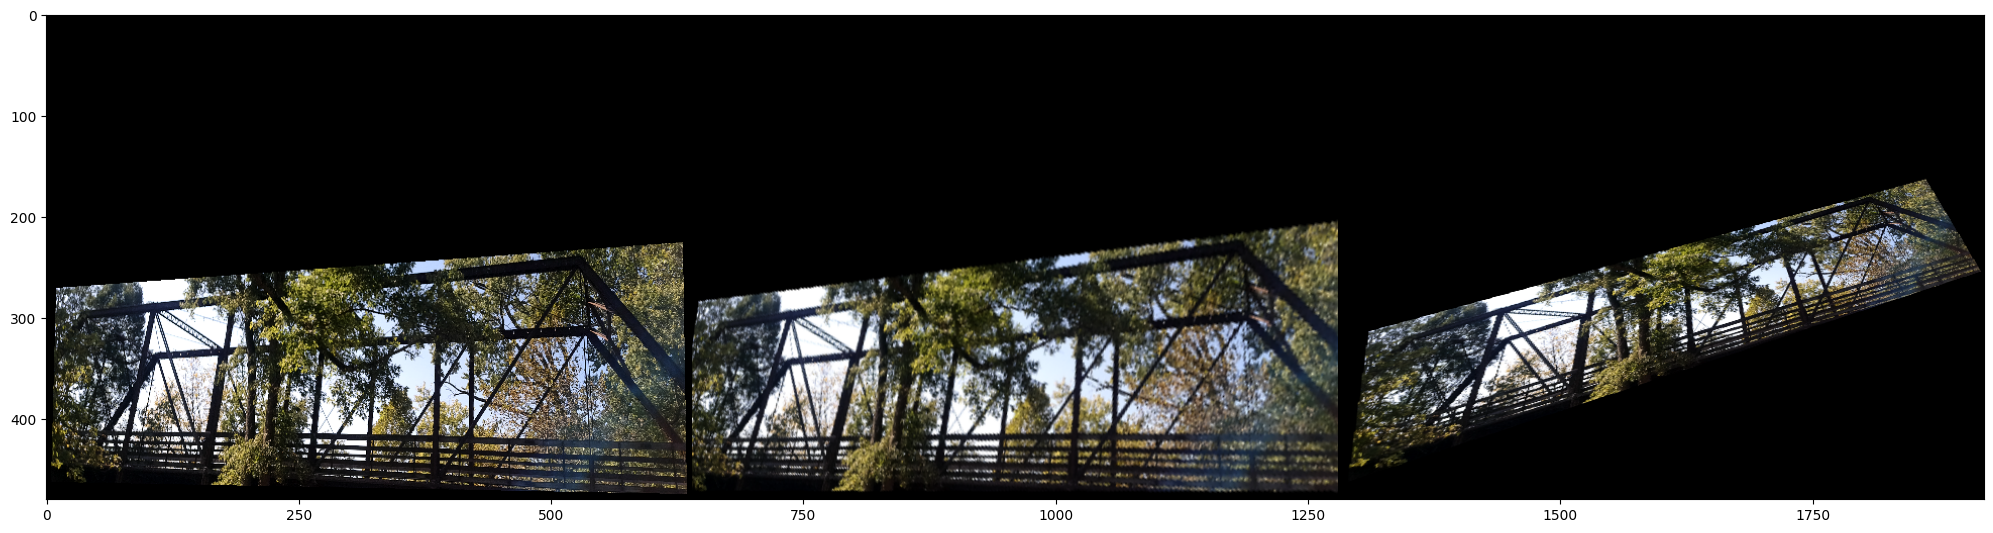

In [ ]:
comb_imgs = np.hstack((image1, img2_rect, image2))
plt.figure(figsize=(25,10))
plt.imshow(comb_imgs)
# plt.savefig('/home/thomas/ScoreFunc/maho_rect.png',dpi=600)
plt.show()

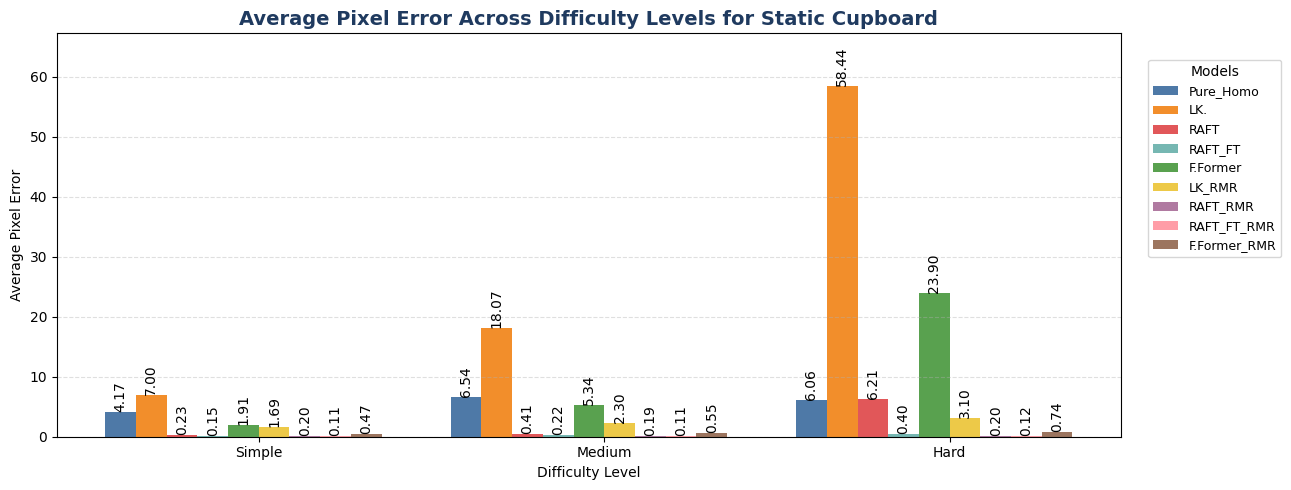

In [ ]:
plot_progress3(metxs, tit="Average Pixel Error Across Difficulty Levels for Static Cupboard")

In [ ]:
K_mm

array([[508.3997,   0.    , 316.0652],
       [  0.    , 677.8663, 254.0068],
       [  0.    ,   0.    ,   1.    ]])

In [ ]:
H12_

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
img2_rect.shape

(480, 640, 3)

In [ ]:
np.median(apt)

np.float32(172.21875)

In [ ]:
uv_flow_pr[0:5,:]

tensor([[49.1857, 19.7209],
        [49.1860, 19.7264],
        [49.1770, 19.7219],
        [49.1595, 19.7179],
        [49.0697, 19.6377]], device='cuda:0')

In [ ]:
gt_flow[0:5,:]

tensor([[495.1953, -40.9149],
        [495.4933, -40.7023],
        [495.7932, -40.4894],
        [496.0950, -40.2762],
        [496.3988, -40.0627]])

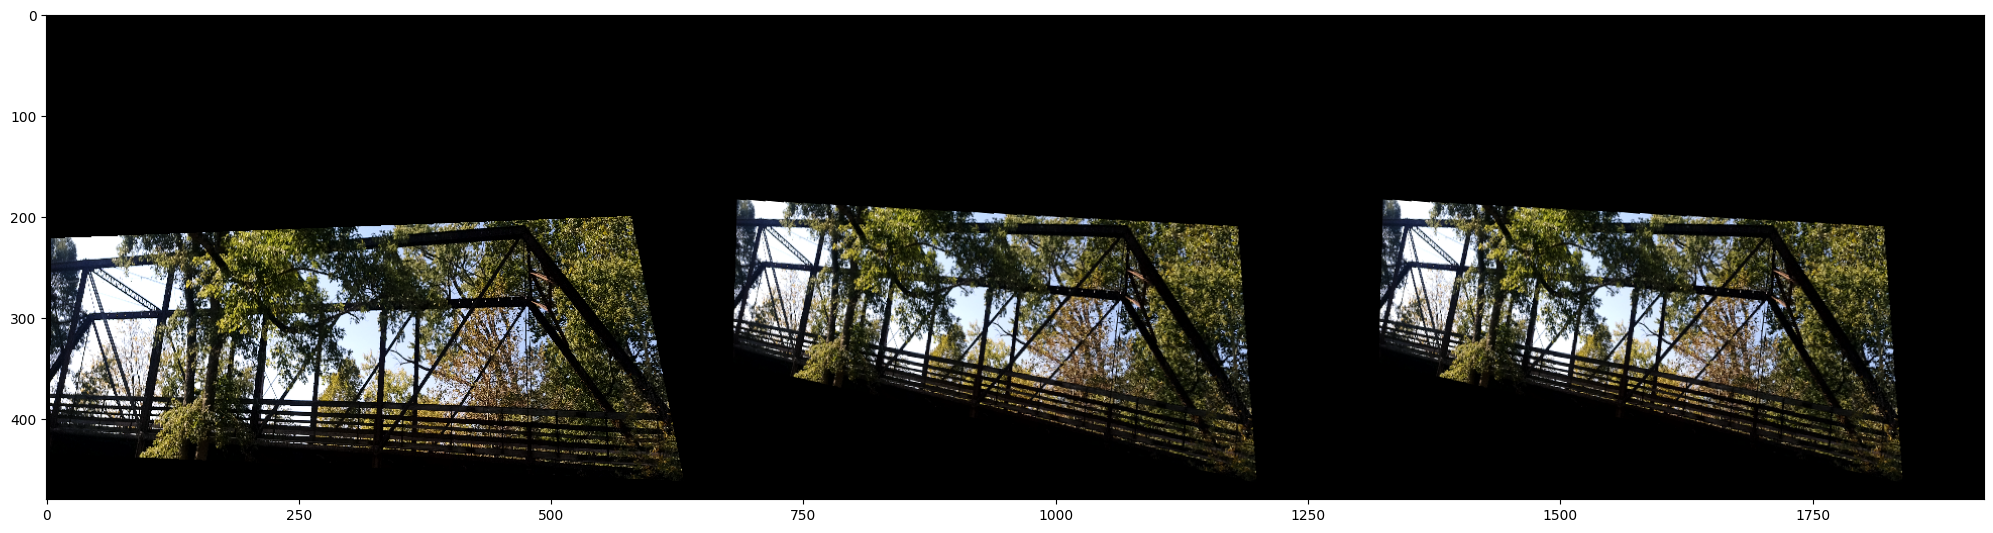